<style>
ol{
  list-style-type: none;
  padding-left: 2em;
  counter-reset: compteur;
}
ol li{
  counter-increment: compteur;
}
ol li::before{
  content: counters(compteur, ".") ". ";
}
</style>

<font color="#1046C2" size="5px" ><b>
TRAITEMENT DISTRIBUE DE DONNEES MASSIVES EN SPARK</b>
</font>

<br/>Ce projet a pour objectif de mettre en pratique les concepts avancés de traitement distribué pour analyser et manipuler des ensembles de données à grande échelle. Il illustre l'application de technologies comme **Apache Spark** pour résoudre des problématiques liées à l'analyse de graphes massifs et au calcul de composantes connexes, dans un environnement distribué.

<font color="#1046C2"><b>Objectif du  projet</b></font>

Trouver dans un réseau connecté, tous les individus reliés, indirectement ou non, à un individu en particulier.
L'intérêt est multiple mais à l'ère des réseaux sociaux un exemple évident est de trouver toutes les relations, directs ou non d'un individu sur les réseaux sociaux et ainsi savoir si d'une façon ou d'une autre 2 individus sont liés ou en communication.


<font color="#1046C2"><b>Considérations autour du volume de données</b></font>

Un réseau peut-être composé de millions d'individus (Facebook est un réseau pour lequel on pourrait être amené à rechercher les  individus en relation à l'échelle mondiale).
A la fin du processus de création de liaisons, le système aura partitionné les billions d'enregistrements dans des sets disjoints nommés profiles : chaque profile correspond à une seule personne.

Ce processus nécessite une haute scalabilité des algorithmes parallélisés.
C'est possible seulement avec une architecture distribuée.

Nous allons proposer l'algorithme <i><b><font color="#2809a6" size="3px">"Computation of Connected Component in Graphs", </font> CCF algorithm, </b></i> implémenté en spark.


<br/><font color="#1046C2" size="5px" ><ins><b>
Algorithme CCF</ins> </b>
</font>

<font color="#1046C2"><ins><b>1 Description de l'algorithme</b></ins></font>

L'algorithme que nous allons implémenter aura pour but de déterminer pour chaque individu l'identifiant de son réseau de relation.
Le réseau sera représenté par un ensemble de graphes. Un graphe connecté correspondra donc à un réseau d'individus en relation.

Par convention, l'identifiant de chaque graphe connecté sera le plus petit des identifiants des nœuds qui composent le graphe connecté.
Il s'agit d'une convention, nous aurions pu choisir l'identifiant le plus grand.
<br/>

<br/>Nous allons déployer un algorithme qui fait appel de manière itérative à 2 fonctions successives ceci jusqu'à trouver pour chaque nœud, l'identifiant le plus petit des nœuds qui lui sont reliés. <br/>
Les 2 fonctions en question sont :
*   CCF-Iterate
*   CCF-Dedup

</br>**En entrée de l'algorithme nous avons** : la liste de toutes les arêtes du graphe <br/>
**En sortie de l'algorithme nous avons** : une map contenant pour chaque nœud du graphe, l'identifiant du composant connecté dans lequel il se trouve, soit l'identifiant le plus petit des nœuds qui lui sont reliés  => Map(node, idComponent)

<br/><ins><b>L'algorithme est itératif :</b></ins>
*   L'entrée de la première itération sera la liste des arêtes du graphe.
*   <ins><b>Pour chaque itération :</b></ins>
<ul>
    <li><ins><b>CCF-iterate</b></ins></li>
            <ol>
            <li><i>En entrée</i> comprendra une liste de paires clé/valeurs avec </br> <b>clé = {Identifiant d'un noeud ayant pour une itération donnée l'identifiant le plus petit du graphe dans lequel il se trouve}</b> </br>et</br>  <b>valeurs = {Liste des identifiants des noeuds reliés à IdNoeud }</b>. Posons cette paire = idNoeud/ListeIdRelies</li>
            <li>si parmi les identifiants de la liste de valeurs ListeIdRelies, on a un identifiant IdComposantTemporaire plus petit que celui dans la clé, alors cet identifiant prendra la place de la clé. <b>Dans ce cas on note qu'une nouvelle paire clé/valeur a été créée.</b>
            <li><i>En sortie</i> retournera une liste de clé/valeur avec la clé étant l'identifiant minimal détecté pendant cette itération IdComposantTemporaire et la valeur étant un identifiant quelconque parmi ListeIdRelies</li>
            <li>on constate qu'une nouvelle paire a été créée</li>
        </ol>
    <li><ins><b>CCF-dedup</b></ins></li>
        <ol>
            <li><i>En entrée</i>  on a donc une liste de paires idNoeud/IdComposantTemporaire</li>
            <li>on fait un regroupement par idNoeud (groupByKey) et on obtient ainsi une paire idNoeud/ListeIdRelies</li>
            <li>on ré-itère ensuite avec CCF-iterate</li>
        </ol>
    </li>
</ul>

*   L'algorithme se termine lorsque pour une itération, il n'y aura eu aucun nouvelle paire clé/valeur de créé.


</br>Spark possède 2 manières d'organiser les données : RDD et DataFrame. Etant donnée les volumes très importants des données, cette manière de les organiser aura un très fort impact sur les performances des algorithmes les traitant.
Nous allons comparer la performance de notre algorithme basé sur des RDDs et ensuite basé sur des Data Frames.


<font color="#1046C2"><ins><b>2 Implémentation de CCF en Spark RDDs </b></ins></font>

<font color="#1046C2" style="padding-left: 50px">2.1 Implémentation avec des RDDs</font>


In [ ]:
# initialize nb_new_pair as a spark accumulator
# cet accumulator servira a comme indicateur de fin d'itérations, indique si une nouvelle paire clé/valur a été créée.
nb_new_pair = spark_context.accumulator(0)

# Implémentation de la fonction CCF-iterate
def ccf_iterate_rdd(x) :
    key, values = x
    min, value_list = key, []
    global nb_new_pair

    for v in values :
        if v < min :
            min = v
        value_list.append(v)
    if min < key :
        yield (key, min)
        for v in value_list :
          if min != v :
              nb_new_pair +=1
              yield (v, min)


# Implémentation de la fonction CCF-dedup
def ccf_dedup_rdd(rdd):
      """Recieve an RDD with (k, v) and return a new RDD resulting of the concatenation of the
    original input RDD and itself where keys & values were inverted (v, k)"""
    rdd.distinct().union(rdd.map(lambda x : (x[1], x[0])))

    """Recieve an RDD alreday processed by iterate_map_rdd(), and for each component
    count new pairs with count_nb_new_pair(), the return RDD is sorted by keys"""
    return rdd.groupByKey().flatMap(lambda x: ccf_iterate(x)).sortByKey()


# Implémentation de la fonction itérative
def compute_cc_rdd(rdd):
    """Recieve a preprocessed RDD and compute CCF according to several iterations jobs of iterate_map/reduce_rdd, dedup.
    When no new pair were counted: return an RDD with the componentIDs of each group of connected edges"""
    nb_iteration = 0
    while True:
        nb_iteration += 1
        start_pair = nb_new_pair.value

        rdd = ccf_dedup_rdd(rdd)
        nbPartitions = rdd.getNumPartitions()
        print(f"Number of new pairs for iteration #{nb_iteration}\t:\t{nb_new_pair.value}")
        print(f"Number of Partitions\t:\t{nbPartitions}")

        if start_pair == nb_new_pair.value:
            print("\nNo new pair, end of computation")
            break
    return rdd



<font color="#1046C2">2.2 Vérification de l'algorithme</font>

Nous allons vérifier que notre algorithme tourne correctement sur un jeu de données simple. Il contient 4 composants connectés.

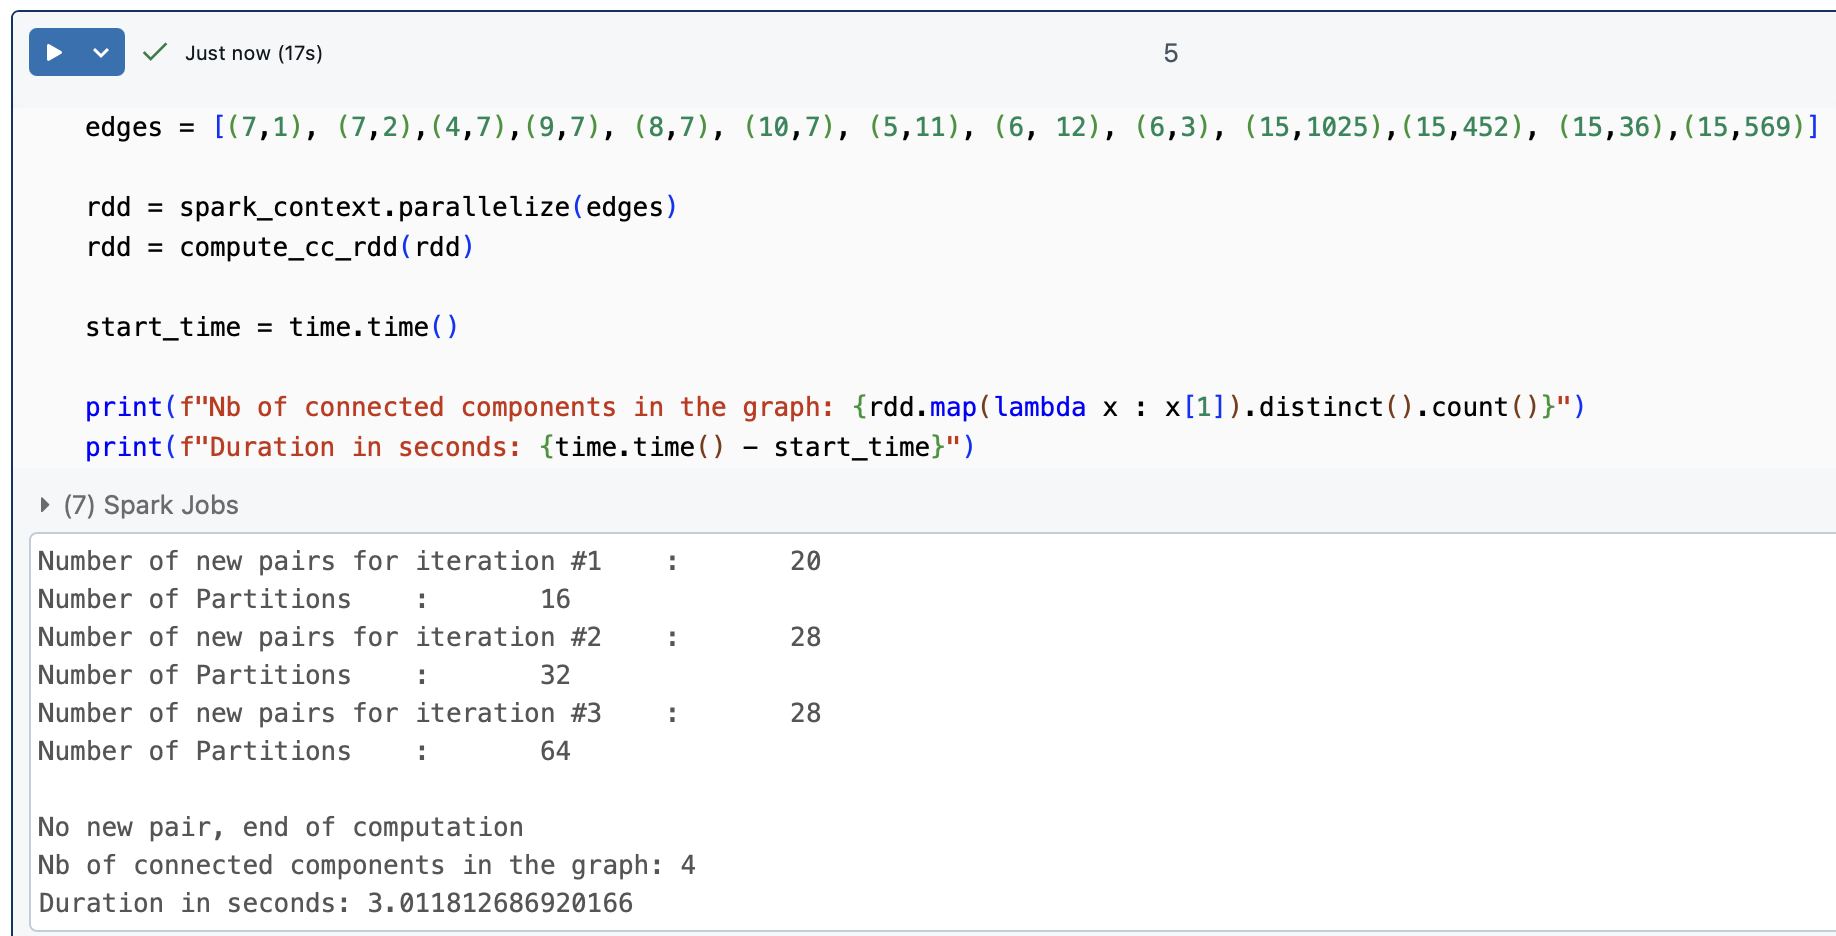

<b>L'algorithme a bien détecté les 4 composants connectés.
<br/>Nous pouvons maintenant l'appliquer à des graphes plus grands. </b>

<font color="#1046C2">2.3 Analyse de l'implémentation en RDDs</font>

Comme premier exemple, prenons un jeu de données trouvé sur le site <blue><i>https://snap.stanford.edu/data/</i></blue>.

Les données représentent un réseau social en ligne de type "qui fait confiance à qui" du site généraliste de critiques de consommateurs Epinions.com. Les membres du site peuvent décider s'ils souhaitent se "faire confiance" mutuellement.
<br/>Une application concrête sera par exemple de n'autoriser la consultation des publications d'un membres qu'aux autres membres qui lui sont connectés directement ou indirectement.


<br/>Jeu de données constitué de :
*   **281 903** membres/**noeuds**
*   **2 312 497** relations de confiance directe/**arêtes**





<br/><mark><i>Afin de mieux analyser les performances de l'algorithme mais aussi de comprendre le fonctionnement distribué de spark, nous allons le tester dans Databricks.</i></mark>

<br/>Résultat du lancement de cet algorithme pour le jeu de données Epinions.txt


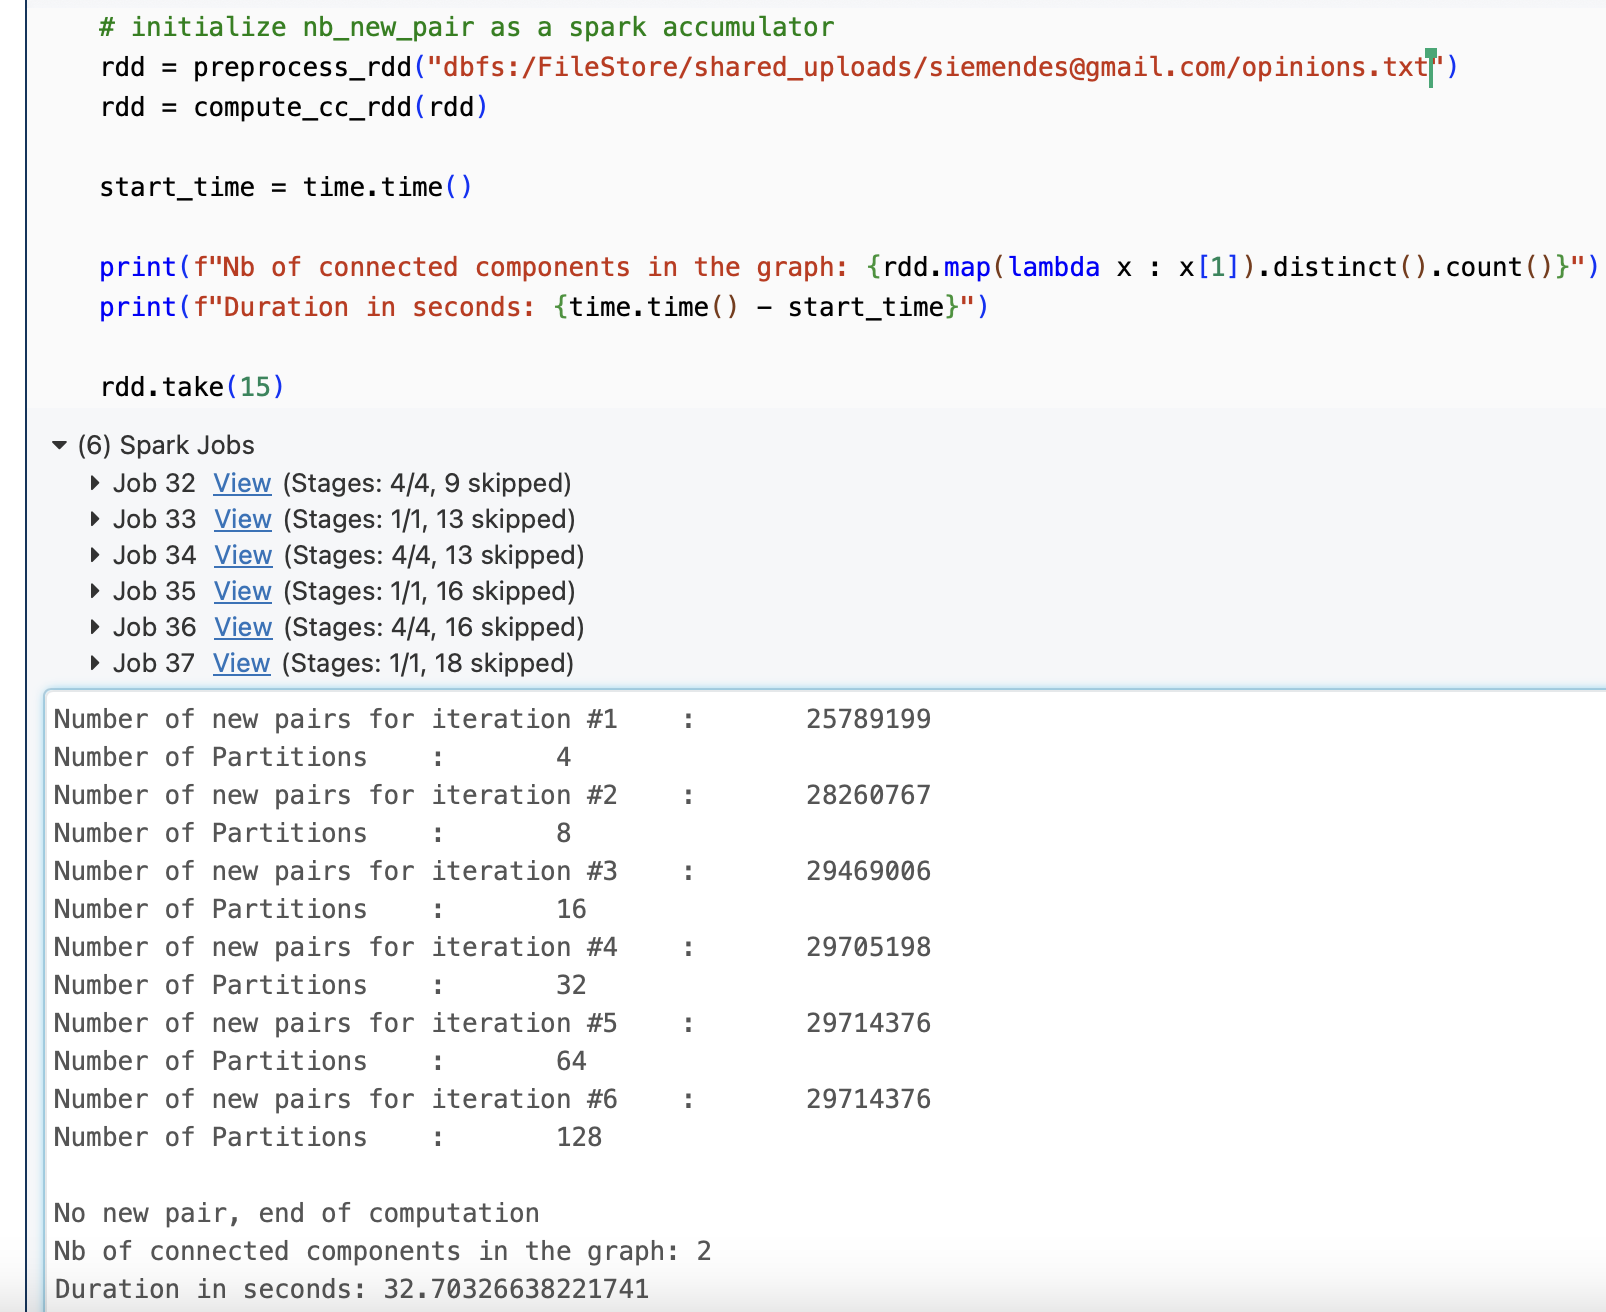

<b><br/>L'algorithme a été exécuté en 32s.
<br/>2 composants connectés ont été détectés.
<br/>L'algorithme a été exécuté en 6 itérations ayant utilisé jusqu'à 128 partitions.
</b>

<br/>Nous constatons un long temps de traitement et de nombreuses partitions utilisées.
<br/>Nous devons optimiser notre algorithme afin d'obtenir de meilleurs temps de traitement et pouvoir ainsi l'utiliser pour des jeux de données bien plus grands que celui proposé ci dessus.



<br/><font color="#1046C2">2.4 Optimisation de l'implémentation en RDDs</font>


Nous pouvons orienter notre optimisation sur 2 axes : l'algorithme lui même et la configuration de l'environnement spark d'exécution de l'algorithme.

<ul>
    <li><ins>Optimisations de l'algorithme</ins></li>
            <ul>
            <li><i><b>Mise en cache</b></i> : la mise en cache des données intermédiaires évite le recalcul des mêmes RDDs pendant les opérations de transformations ou les actions ce qui représente un gain considérable de temps. La mise en cache des données intermédiaire est particulièrement efficace pour les algorithmes itératifs en permettant une convergeance plus rapide.</li>
            <li> <i><b>Persistance des données</b></i> : minimise le shuffling des données à travers le cluster pendant les opérations d'aggrégation comme le groupByKey utilisé dans la fonction ccf_dedup. Il y a moins de traffic dans le cluster et les opérations sont plus efficaces</li>
        </ul>
    <li><ins>Optimisations de la configuration spark</ins></li>
        <ul>
            <li> <i><b>Nombre de partitions </b></i> : l'algorithme utilise des fonctions d'aggrégation qui sont très couteuses sur des données rparties sur trop de partitions différentes. Nous devons donc les limiter. Limitons les à 100 partitions.</li>
            <li> <i><b>Gestion du cache </b></i> : nous allons utiliser des caches pour nos données intermédiaires. Nous pouvons configurer spark afin d'améliorer ses performances également.</li>
        </ul>
    </li>
</ul>

In [ ]:
# optimisation de la configuration de l'environnement d'exéution de spark
spark_conf = SparkConf().setAppName("PySpark App by Sophie & Younes") \
    .set("spark.sql.shuffle.partitions",100) \
    .set('persistence_level','MEMORY_ONLY') \
    .set("spark.sql.inMemoryColumnarStorage.compressed", 'true') \
    .set("spark.sql.inMemoryColumnarStorage.batchSize",10000) \
    .set("spark.dynamicAllocation.shuffle tracking.enabled",'true' )

spark_session = SparkSession \
    .builder.config(conf=spark_conf) \
    .appName("PySpark App by Sophie & Younes") \
    .getOrCreate()

# optimisation de la fonction CCF-dedup
def ccf_dedup_rdd(rdd):
    """On a persisté les données intermédiaires et mis en cache les données après chaque itération"""
    rdd = rdd.union(rdd.map(lambda x : (x[1], x[0]))).distinct().persist()
    return rdd.groupByKey().flatMap(lambda x: ccf_iterate_rdd(x)).cache().sortByKey()

# libération de la mémoire après chaque itération
def compute_cc_rdd(rdd):
    """Recieve a preprocessed RDD and compute CCF according to several iterations jobs of iterate_map/reduce_rdd, dedup.
    When no new pair were counted: return an RDD with the componentIDs of each group of connected edges"""
    nb_iteration = 0
    while True:
        nb_iteration += 1
        start_pair = nb_new_pair.value

        rdd = ccf_dedup_rdd(rdd)
        rdd.unpersist()
        nbPartitions = rdd.getNumPartitions()
        print(f"Number of new pairs for iteration #{nb_iteration}\t:\t{nb_new_pair.value}")
        print(f"Number of Partitions\t:\t{nbPartitions}")

        if start_pair == nb_new_pair.value:
            print("\nNo new pair, end of computation")
            break
    return rdd

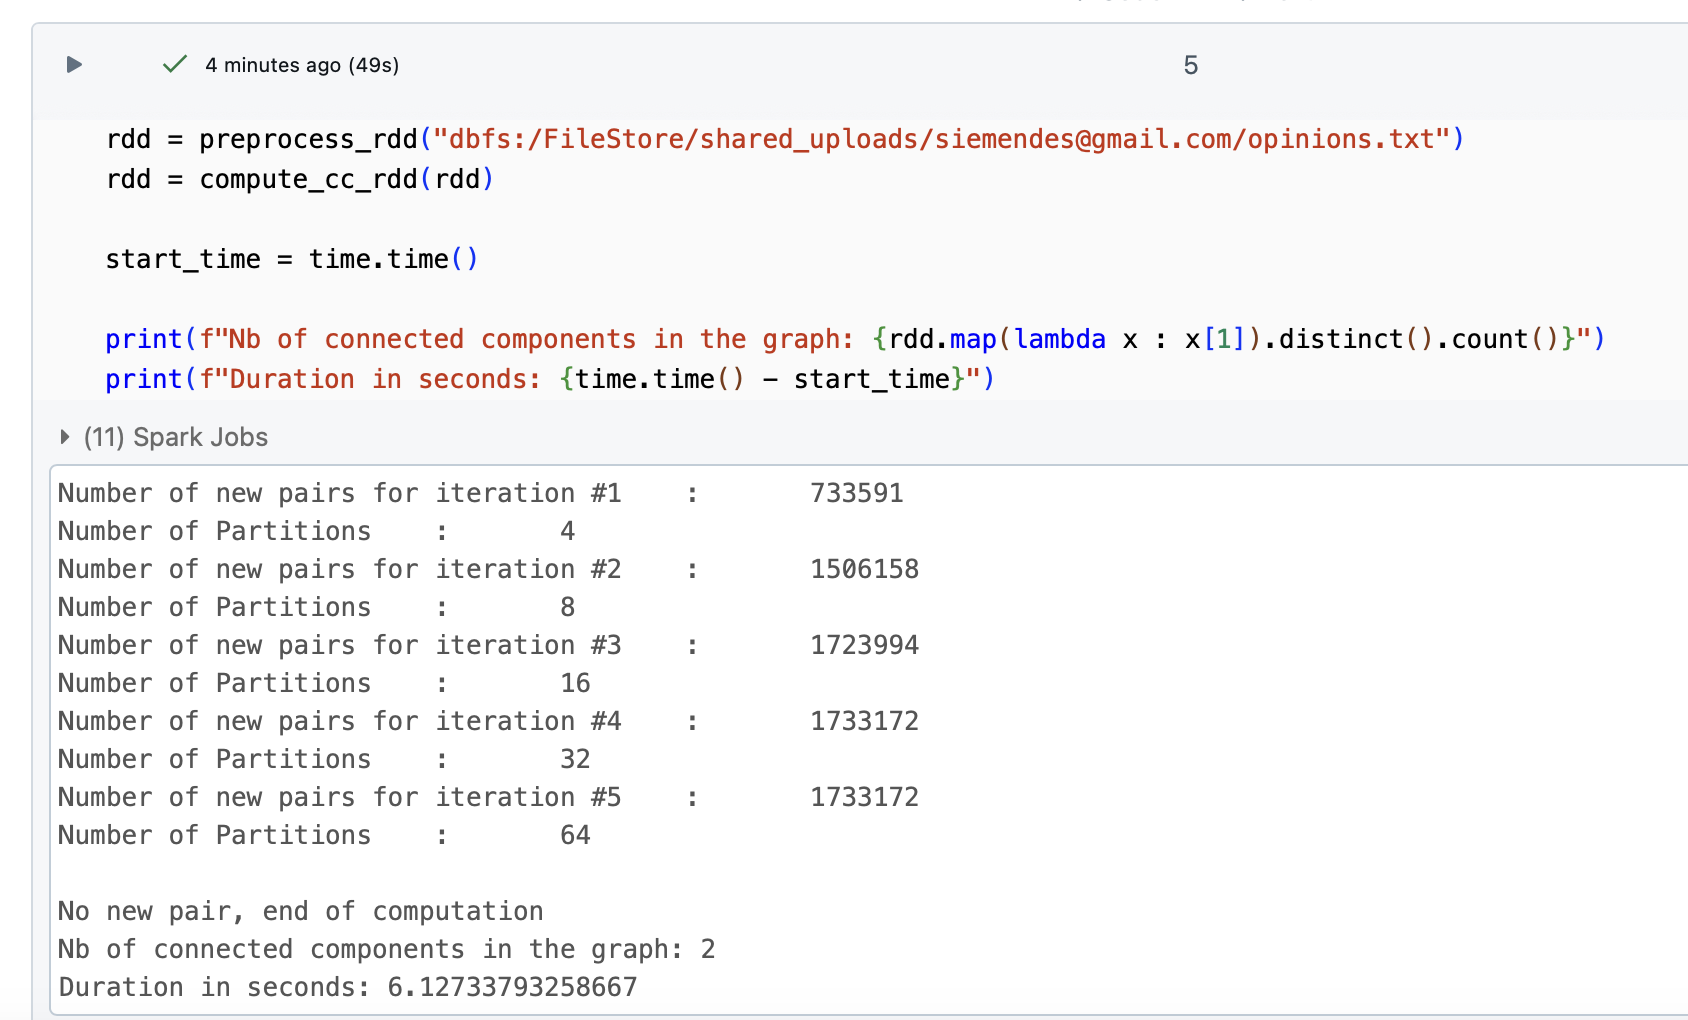

<b>Cette fois l'algorithme a été exécuté en 6s. Les optimisations effectuées ont permis de réduire de 75% le temps d'exécution.</b>


<font color="#1046C2"><ins><b>3 Implémentation en Spark Data Frames </b></ins></font>

<font color="#1046C2" style="padding-left: 50px">3.1 Implémentation avec des Data Frames</font>

Nous pouvons partir du principe que, quelque soit la manière d'organiser les données RDDs ou Data Frames, l'utilisation des caches et de persist optimisera l'algorithme. Nous allons donc tout de suite implémenter un algorithme en Data Frame optimisé à l'aide des mêmes techniques.

In [ ]:
nb_new_pair = spark_context.accumulator(0)

def preprocess_df(path):
    """Recieve an RDD with the raw data and return a new RDD without multilines headers
    starting with '#', and columns splitted according to the tab separator"""
    df = spark_session.read.format("csv").option("header", "false").load(path)

    """Recieve a DF with the raw data and return a new DF without multilines headers
    starting with '#', and columns splitted according to the tab separator"""
    col_name = df.columns[0]
    return df.filter(f"{col_name} NOT LIKE '#%'")\
                .withColumn('k', split(df[col_name], ';').getItem(0)) \
                .withColumn('v', split(df[col_name], ';').getItem(1)) \
                .drop(col_name)\
                .withColumn("k",col("k").cast(IntegerType())) \
                .withColumn("v",col("v").cast(IntegerType()))


nb_new_pair = spark_context.accumulator(0)

def ccf_dedup_df(df) :
  return df.union(df.select(col("v").alias("k"), col("k").alias("v"))).distinct().persist()


def ccf_iterate_df(df) :
    global nb_new_pair
    df = df.groupBy(col("k")).agg(collect_set("v").alias("v"))\
                      .withColumn ("min", least(col("k"), array_min("v")))\
                      .filter((col("k")!=col('min')))

    nb_new_pair += df.withColumn("count", size("v")-1).select(sum("count")).collect()[0][0]

    return df.select(col("min").alias("a_min"), concat(array(col("k")), col("v")).alias("valueList"))\
                                                    .withColumn("valueList", explode("valueList"))\
                                                    .filter((col('a_min')!=col('valueList')))\
                                                    .select(col('a_min').alias("k"), col('valueList').alias("v"))


def compute_cc_df(df):
    """Recieve a preprocessed DF and compute CCF according to several iterations jobs of iterate_map/reduce_df, dedup.
    When no new pair were counted: return a DF with the componentIDs of each group of connected edges"""
    nb_iteration = 0
    while True:
        nb_iteration += 1
        nb_pairs_start = nb_new_pair.value

        df = ccf_dedup_df(df)
        df = ccf_iterate_df(df)

        df.unpersist()
        print(f"Number of new pairs for iteration #{nb_iteration}:\t{nb_new_pair.value}")
        if nb_pairs_start == nb_new_pair.value:
            print("\nNo new pair, end of computation")
            break
    return df

<font color="#1046C2" style="padding-left: 50px">3.2 Vérification de l'algorithme</font>

Nous allons vérifier que notre algorithme tourne correctement sur un jeu de données simple. Il contient 4 composants connectés.

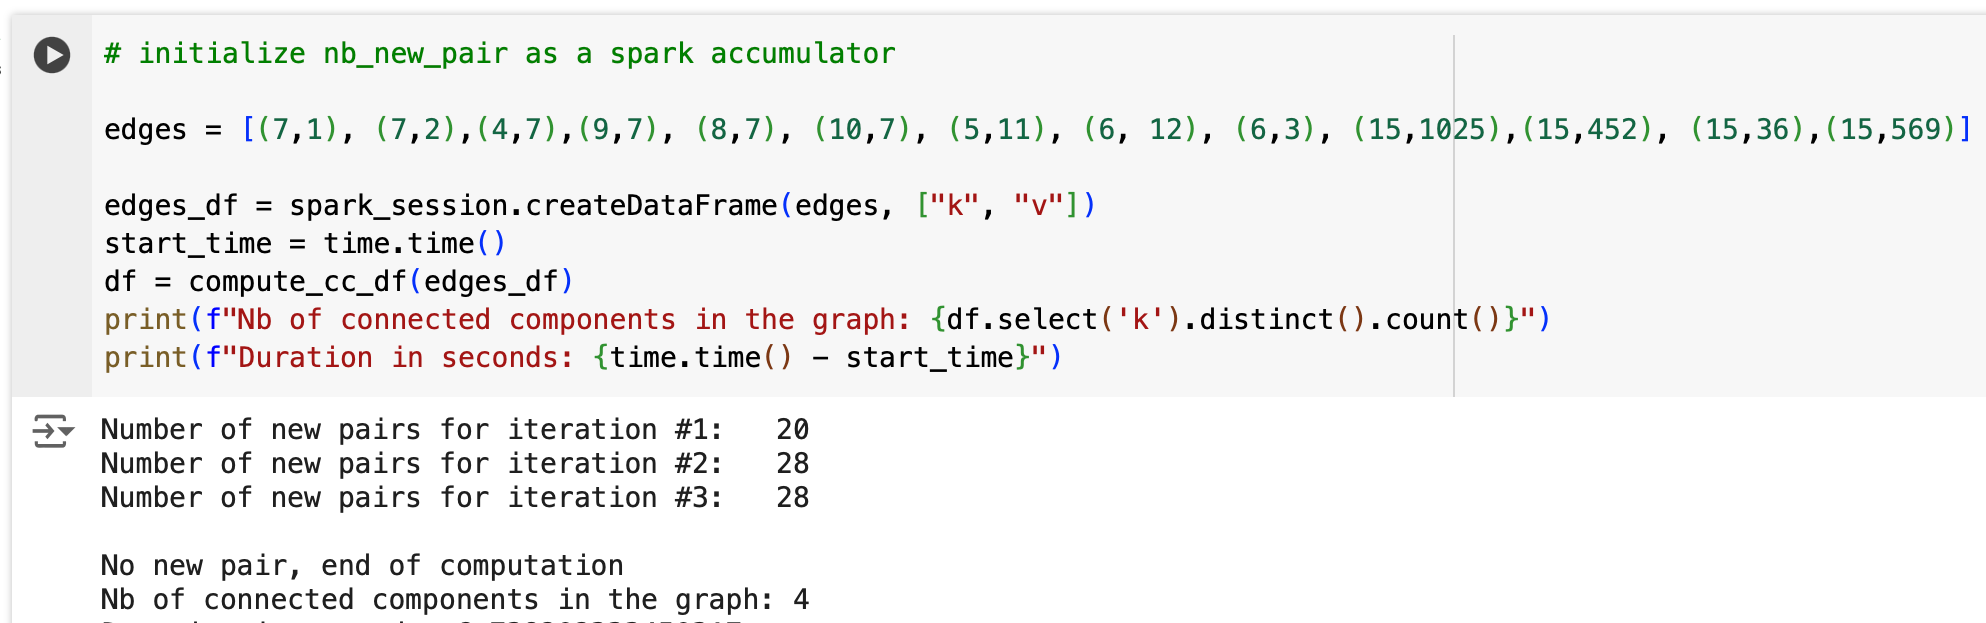

<b>L'algorithme a bien détecté les 4 composants connectés. Il effectue correctement le traitement demandé.</b>





<font color="#1046C2"><ins><b>4 Comparaison des performance des algorithmes en RDD et en Data Frame</b></ins></font>

Nous allons effectuer la comparaison des algorithmes sur un jeu de données massif trouvé toujours sur le site <blue><i>https://snap.stanford.edu/data/</i></blue>.

Les nœuds représentent des pages web et les arêtes représentent les hyperliens entre elles. Les données ont été publiées en 2002 par Google dans le cadre du Google Programming Contest.


<br/>Jeu de données constitué de :
*   **875 713** pages/**noeuds**
*   **5 105 039** hyperliens/**arêtes**


<br/>L'algorithme optimisé en RDD pour le jeu de données opinions.txt a été exécuté en 8,5 minutes
<br/>L'algorithme optimisé en Data Frame pour le même jeu de données a quant à lui été exécuté en 25% moins de temps soit en un peu plus de 6,2 minutes.

<b>Nous pouvons en conclure que les algorithmes optimisés sur des données massives sont plus performants en utilisant des Data Frames que des RDDs.</b>


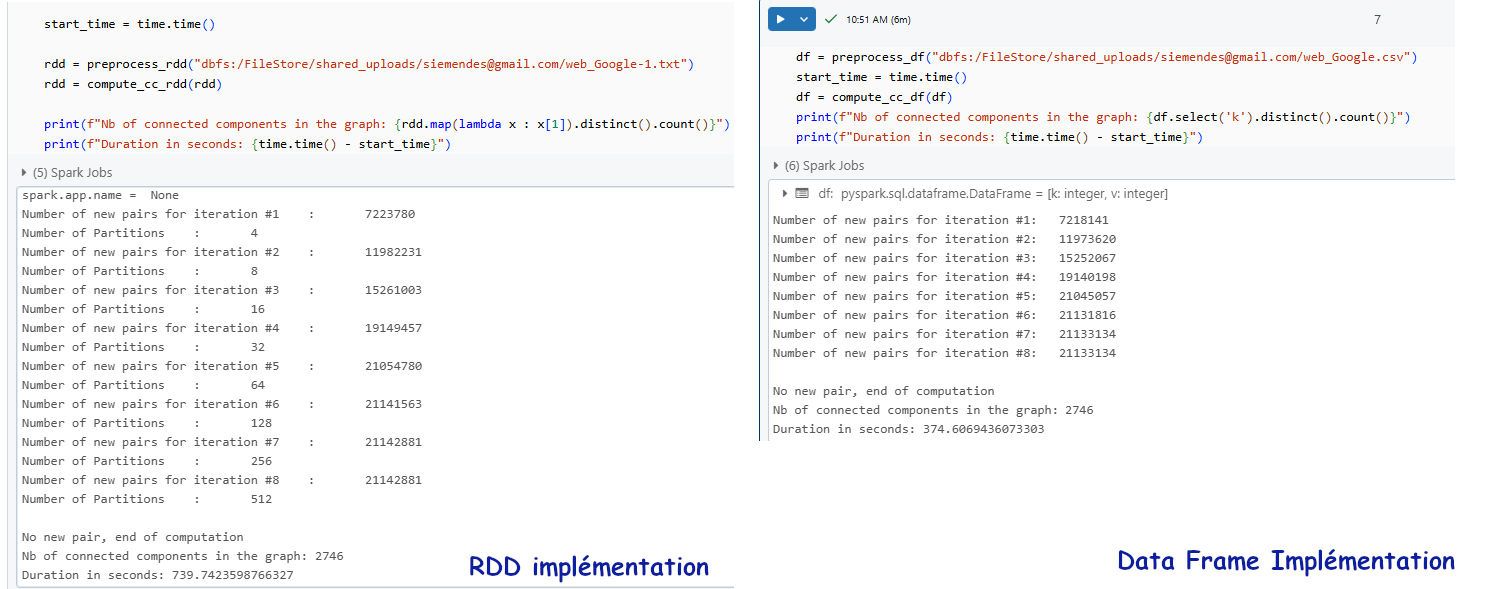

<font color="#1046C2" size="5px" ><ins><b>
Conclusion</ins> </b>
</font>

<br/><b><font color="#2809a6">Quelque soit l'algorithme, ses performances ou ses actions, pour traiter des données massives, l'utilisation des Data Frames est une meilleure option que l'utilisation de RDDs.</font> </b>

Nous avons aussi démontré qu'il y a bien des façons d'optimiser nos algorithmes, RDD ou Data Frame, afin de les rendre plus performants. Nous n'en avons vu qu'une petite partie mais il reste de nombreux paramètres sur lesquels jouer pour améliorer nos performances comme par exemple l'utilisation de buckets plutôt que de partitions, le choix du type de fichier à utiliser,l'utilisation de mapPartition plutôt que de map... et bien d'autres encore. </b>

<b><font color="#2809a6">L'optimisation des algorithmes, dans un contexte de données massives et de temps de traitement puvant être extrèmement longs est cruciale. Les optimisations peuvent porter sur l'algorithme lui même mais aussi sur le contexte et la configuration de l'environnement d'exécution de spark.</font> </b>
